In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import Preprocessing.preprocessing as pp
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pylab
import math
import Preprocessing.image_processing as ip

In [3]:
import tensorflow as tf

In [4]:
 from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

Load in the data from a csv of pixel data, and a csv of labels

In [5]:
train_csv_x = '/Users/connieli/Documents/229a/Data/train_images.csv'
train_csv_y = '/Users/connieli/Documents/229a/Data/train_labels.csv'

X, Y = pp.load_XY(train_csv_x, train_csv_y)

Reshape the $Y$ vector (works better during the fitting)

Load the validation set

In [6]:
val_csv_x = '/Users/connieli/Documents/229a/Data/val_images.csv'
val_csv_y = '/Users/connieli/Documents/229a/Data/val_labels.csv'
X_val, Y_val = pp.load_XY(val_csv_x, val_csv_y)

## SVM

In [7]:
Ycol = Y[:,1]
Y_valcol = Y_val[:,1]

In [45]:
# Ycol = Y[:,1]
# svmodel = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=0.3, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=10)
# svmodel.fit(X, Ycol)
# svmodel.score(X, Ycol)

0.62716666666666665

In [46]:
# Y_valcol = Y_val[:,1]
# svmodel.score(X_val, Y_valcol)

0.56299999999999994

In [8]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_val_scaled = scaler.transform(X_val)

### Unscaled SVM

In [86]:
Cs = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0 ]
Ycol = Y[:,1]
Y_valcol = Y_val[:,1]

svm_train_score = np.zeros(len(Cs))
svm_val_score = np.zeros(len(Cs))

for i in range(len(Cs)):
    currC = Cs[i]
    svmodel = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=currC, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=10)
    svmodel.fit(X, Ycol)
    svm_train_score[i] = svmodel.score(X, Ycol)
    svm_val_score[i] = svmodel.score(X_val, Y_valcol)


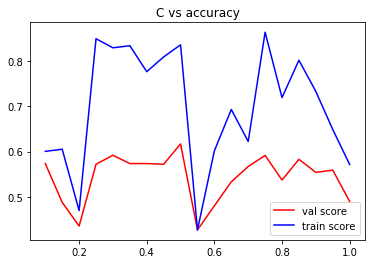

In [88]:
plt.plot(Cs, svm_val_score,'r', label="val score")
plt.plot(Cs, svm_train_score, 'b', label="train score")
plt.title("C vs accuracy")
plt.legend()
plt.show()

In [90]:
svm_train_score

array([ 0.6005    ,  0.60533333,  0.46933333,  0.85016667,  0.83      ,
        0.83466667,  0.77716667,  0.80983333,  0.83666667,  0.4265    ,
        0.60183333,  0.69333333,  0.6225    ,  0.8645    ,  0.71966667,
        0.8025    ,  0.73333333,  0.649     ,  0.5715    ])

### Scaled SVM

In [ ]:
Cs = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0 ]
Ycol = Y[:,1]
Y_valcol = Y_val[:,1]

svm_train_score = np.zeros(len(Cs))
svm_val_score = np.zeros(len(Cs))
for i in range(len(Cs)):
    currC = Cs[i]
    svmodel = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=currC, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=10)
    svmodel.fit(X_scaled, Ycol)
    svm_train_score[i] = svmodel.score(X_scaled, Ycol)
    svm_val_score[i] = svmodel.score(X_val_scaled, Y_valcol)

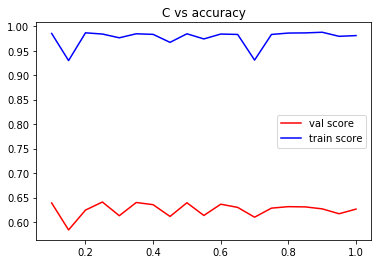

In [75]:
plt.plot(Cs, svm_val_score,'r', label="val score")
plt.plot(Cs, svm_train_score, 'b', label="train score")
plt.title("C vs accuracy")
plt.legend()
plt.show()

In [79]:
svm_train_score[7]
# svm_val_score[7]

0.96699999999999997

### Train on 96x96 images

Fit a logistic regression to the data

In [19]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, Y)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predict on the training data to calculate the accuracy (not the final evaluation metric for models)

In [25]:
y_pred_train = clf.predict(X)

In [27]:
print("Accruacy on train set: ",1 - np.mean(np.abs(y_pred_train-Y.T)))

Accruacy on train set:  0.9236666666666666


Predict on the validation data set

In [29]:
y_pred_val = clf.predict(X_val)

In [30]:
print("Accruacy on validation set: ",1 - np.mean(np.abs(y_pred_val-Y_val.T)))

Accruacy on validation set:  0.5880000000000001


We can see that unregularized logistic regression performs poorly out of sample which is expected considering the input has $\approx 27,000$ features but we train it on $6,000$ examples which in turn creates problems of overfitting to the training data. Below we try different values of regularization and compare how that affects performance on both the training and the validation set.

In [68]:
reg = [np.exp(-i) for i in range(0, 30, 2)]
reg = sorted(reg)

In [69]:
acc_train = []
acc_val = []
for i, c_i in enumerate(reg):
    print(i)
    # fit a logistic regression using regularization c_i
    clf = LogisticRegression(random_state=0, solver='lbfgs', C=c_i, multi_class='multinomial').fit(X, Y)
    # evaluate accuracy on the training set
    y_pred_train = clf.predict(X)
    acc_train.append(1 - np.mean(np.abs(y_pred_train-Y.T)))
    # evaluate accuracy on the validation set
    y_pred_val = clf.predict(X_val)
    acc_val.append(1 - np.mean(np.abs(y_pred_val-Y_val.T)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


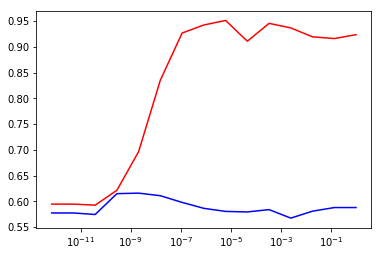

In [78]:
plt.plot(np.array(reg), np.array(acc_train),'r')
plt.plot(np.array(reg), np.array(acc_val), 'b')
plt.xscale('log')
plt.show()